<a href="https://colab.research.google.com/github/prysykes/adversarial_attacks/blob/main/FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
pathh = 'MNISTClassifier'

for parent, dirs, files in os.walk(pathh, topdown=False):
  for file in files:
    file_path = os.path.join(parent, file)
    os.remove(file_path)
  for dir in dirs:
    dir_path = os.path.join(parent, dir)
    os.rmdir(dir_path)

  os.rmdir('/content/MNISTClassifier')

In [3]:
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28, 28)).astype("float32") / 255
images = np.expand_dims(images, axis=3)
test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
test_images = np.expand_dims(test_images, axis=3)
x_train, x_test = images[10000:], images[:10000]
y_train, y_test = labels[10000:], labels[:10000]

Inspect data

2


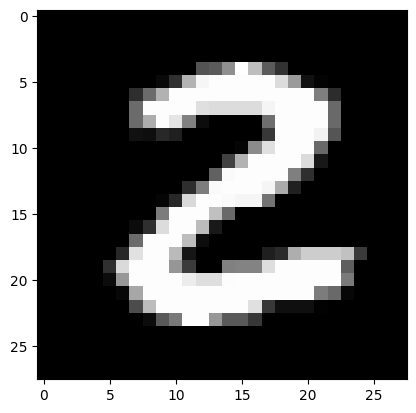

In [4]:
x_test[5].shape
digit = x_test[25]
fig = plt.figure
plt.imshow(digit, cmap='gray')
print(y_test[16])

# number 2 are found in these location: [(5, 2), (16, 2), (25, 2), (28, 2), (76, 2)]

In [5]:
few_twos = []
count = 0
for index, label in enumerate(y_test):
  if count > 9:
    break
  if label == 2:
    few_twos.append((index, label))
    count += 1

print(few_twos)

[(5, 2), (16, 2), (25, 2), (28, 2), (76, 2), (82, 2), (109, 2), (117, 2), (120, 2), (122, 2)]


In [6]:
print(few_twos)

[(5, 2), (16, 2), (25, 2), (28, 2), (76, 2), (82, 2), (109, 2), (117, 2), (120, 2), (122, 2)]


In [94]:
class MNISTClassifierSmall(tf.keras.Model):
  def __init__(self):
    super(MNISTClassifierSmall, self).__init__()

    #define layers
    self.conv1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))
    self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))
    self.conv3 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1))
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(10)

    self.layers_list = [self.conv1, self.conv2, self.conv3, self.flatten, self.dense1]

  @tf.function
  def call(self, *args, **kwargs):
    activation_list = []
    out = args[0]
    for layer in self.layers_list:
      out = layer(out)
      activation_list.append(out)

    if kwargs['training']:
      return out

    else:
      prob = tf.nn.softmax(out)
      return out, prob


In [95]:
model = MNISTClassifierSmall()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

model.save('MNISTClassifierSmall')
# model = keras.models.load_model("MNISTClassifier.keras")

Epoch 1/10
1563/1563 [==============================] - 11s 5ms/step - loss: 0.1213 - accuracy: 0.9627 - val_loss: 0.0624 - val_accuracy: 0.9810
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0443 - accuracy: 0.9859 - val_loss: 0.0476 - val_accuracy: 0.9865
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0297 - accuracy: 0.9905 - val_loss: 0.0479 - val_accuracy: 0.9871
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0204 - accuracy: 0.9929 - val_loss: 0.0726 - val_accuracy: 0.9816
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0135 - accuracy: 0.9953 - val_loss: 0.0547 - val_accuracy: 0.9872
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0102 - accuracy: 0.9966 - val_loss: 0.0690 - val_accuracy: 0.9881
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0576 - val_accurac

In [7]:
class MNISTClassifier(tf.keras.Model):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        # Define the layers
        #for feature extration
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1))
        self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.conv1, self.max_pool1, self.conv2, self.max_pool2,
                           self.flatten, self.dropout1, self.dense1, self.dropout2, self.dense2]
    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:
           out = layer(out)
           activation_list.append(out)

        if kwargs['training']:
          #notice that training is a kw argument checked when fit is called
          #so when model is training, all I need is the output logits to call the loss function upon
          return out
        else:
          prob = tf.nn.softmax(out)
          return out, prob

In [8]:
class SaveFinalTrainingLogitsProp(keras.callbacks.Callback):
  def on_train_end(self, logs):
    self.out = model.predict(x_train)
    self.prob = tf.nn.softmax(self.out)
    print(self.out.shape, self.prob.shape)


In [8]:
model = MNISTClassifier()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

model.save('MNISTClassifier')
# model = keras.models.load_model("MNISTClassifier.keras")

Epoch 1/10
1563/1563 [==============================] - 17s 7ms/step - loss: 0.2674 - accuracy: 0.9161 - val_loss: 0.0682 - val_accuracy: 0.9800
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1008 - accuracy: 0.9699 - val_loss: 0.0559 - val_accuracy: 0.9827
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0728 - accuracy: 0.9776 - val_loss: 0.0450 - val_accuracy: 0.9867
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0632 - accuracy: 0.9813 - val_loss: 0.0404 - val_accuracy: 0.9893
Epoch 5/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0539 - accuracy: 0.9833 - val_loss: 0.0379 - val_accuracy: 0.9894
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0480 - accuracy: 0.9854 - val_loss: 0.0381 - val_accuracy: 0.9888
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0436 - accuracy: 0.9870 - val_loss: 0.0385 - val_accur

## load model and make predictions

In [9]:
# select a few twos from the test dataset and reshape
# twos are at [(5, 2), (16, 2), (25, 2), (28, 2), (76, 2)]

twos_tuple = [(5, 2), (16, 2), (25, 2), (28, 2), (76, 2), (82, 2), (109, 2), (117, 2), (120, 2), (122, 2)]
reshaped_sample_twos = []
for tup in twos_tuple:
  a_two = x_test[tup[0]]
  a_two = np.reshape(a_two, (-1, 28, 28, 1))
  reshaped_sample_twos.append(a_two)
reshaped_sample_twos = np.array(reshaped_sample_twos)
# a_five = np.reshape(x_test[47], (-1, 28, 28, 1))
# print(a_five.shape)

In [98]:
print(reshaped_sample_twos.shape) #the network expects a rank 4 tensor ie. batch, width, hieght, channel

(10, 1, 28, 28, 1)


In [10]:
# location of 2 in x_test # number 2 are found in these location: [(5, 2), (16, 2), (25, 2), (28, 2), (76, 2)]
model = tf.keras.models.load_model('MNISTClassifier')

prediction = []
for sample in reshaped_sample_twos:
  sample_prediction = model.predict(sample)
  prediction.append(sample_prediction)
# print(np.argmax(prediction))
print(np.argmax(prediction[0][1]))

1/1 [==============================] - 0s 28ms/step
2


In [11]:
print(np.argmax(prediction[1][0]))

2


In [17]:
print(prediction)

[(array([[ -9.134992 ,  -7.7646103,  20.865807 ,  -3.2899628, -11.717895 ,
        -17.015156 , -15.861994 ,  -5.493937 ,  -8.166269 , -19.320885 ]],
      dtype=float32), array([[9.3501656e-14, 3.6810179e-13, 1.0000000e+00, 3.2305960e-11,
        7.0644437e-15, 3.5359579e-17, 1.1202625e-16, 3.5654062e-12,
        2.4633699e-13, 3.5248585e-18]], dtype=float32)), (array([[ -6.442524  ,  -8.878513  ,  15.837682  ,  -1.2903374 ,
        -12.28939   , -12.3454685 , -15.789517  ,  -0.02592649,
         -3.9680638 , -13.503057  ]], dtype=float32), array([[2.1078027e-10, 1.8445620e-11, 9.9999988e-01, 3.6424677e-08,
        6.0893093e-13, 5.7572214e-13, 1.8385773e-14, 1.2898001e-07,
        2.5030744e-09, 1.8091693e-13]], dtype=float32)), (array([[ -9.183034 ,  -8.148974 ,  14.980341 ,   0.3985322, -15.808408 ,
        -16.692863 ,  -8.494036 ,  -6.953485 ,  -1.0761036, -12.040946 ]],
      dtype=float32), array([[3.20611385e-11, 9.01708430e-11, 9.99999404e-01, 4.64729794e-07,
        4.252219

In [12]:
print(tf.one_hot(y_test[5], 10)) #creates a 0n-hot encoded output label to enable us calculate the distance

tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [13]:
reshaped_sample_twos[0].shape
print("hh", reshaped_sample_twos[0].shape)
#squeze to drop first dim
squeze_two = np.expand_dims(np.squeeze(reshaped_sample_twos[2]), axis=2)
squeze_two.shape
x = squeze_two
x = np.expand_dims(x, axis=0)
x = tf.convert_to_tensor(x)
y = y_test[5]
y = tf.convert_to_tensor(y)

print(y)
print(x.shape)

hh (1, 28, 28, 1)
tf.Tensor(2, shape=(), dtype=uint8)
(1, 28, 28, 1)


In [28]:
def fgsm(model, x, y, eps):
  # tensor of same shape as x to hold perturbation
  #x coming in is already perturbed version of x
  # delta = tf.zeros_like(x)
  y = tf.one_hot(y, 10)
  y = np.reshape(y, (1,10))
  y_pred = None

  num_iteration = 1
  x = tf.cast(x, tf.float32)
  while (num_iteration < 100):

    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        y_pred = y_pred[1]
        # print("y_pred", y_pred)
        # print("y", y)
        loss = tf.keras.losses.categorical_crossentropy(y, y_pred, from_logits=True)
    gradient = tape.gradient(loss, x)
    gradient /= tf.math.reduce_std(gradient) + 1e-8
    signed_grad = tf.sign(gradient)
    perturbation = eps*signed_grad
    adv_x = x + perturbation
    adv_x = tf.clip_by_value(adv_x, 0, 1) # make sure the perturbed image is still in [0, 1] range
    x = adv_x
    if num_iteration%10 == 0:
      print(f"Num_iterations: {num_iteration} \n Y_Pred: {np.argmax(y_pred)} \n Y: {np.argmax(y)}")
    if np.argmax(y_pred) != np.argmax(y):
      break
    num_iteration += 1
  return adv_x, perturbation

## Attack and plot function

In [39]:
def run_attacks(img_arr, class_arr, model, att_func):
  result = []
  # result contains a tupple of AE and Pertubation

  for img, cls in zip(img_arr, class_arr):
    x_test_adv, perturbation = att_func(model, img, cls, 0.1)
    result.append((x_test_adv, perturbation))

  return result

In [29]:
xb = reshaped_sample_twos[0]
# plt.imshow(x)

In [30]:
x_test_adv, perturbation = fgsm(model, xb, y, 0.01)

Num_iterations: 10 
 Y_Pred: 2 
 Y: 2


## Metrics for large Model

(28, 28, 1)


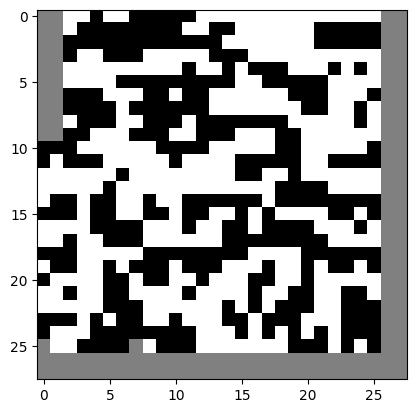

In [17]:
# x_test[5].shape
# digit = x_test[16]
# fig = plt.figure
# plt.imshow(digit, cmap='gray')
# print(y_test[16])

perturbation = np.squeeze(perturbation)
perturbation = np.expand_dims(perturbation, axis=2)
print(perturbation.shape)

plt.imshow(perturbation, cmap='gray')

In [18]:
print(x_test_adv.shape)
print(x.shape)

(1, 28, 28, 1)
(1, 28, 28, 1)


(28, 28, 1)


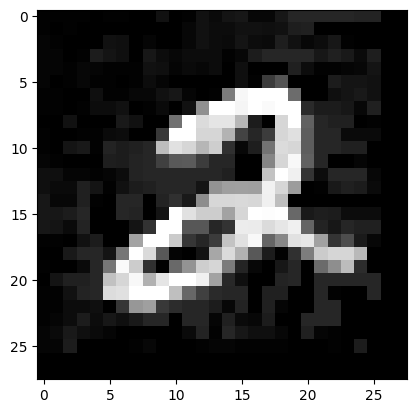

In [19]:
adv_image = np.squeeze(x_test_adv)
adv_image = np.expand_dims(adv_image, axis=2)
print(adv_image.shape)

plt.imshow(adv_image, cmap='gray')

In [20]:
adv_pred = model.predict(x_test_adv)
org_pred = model.predict(x)

org_pred = np.argmax(org_pred[1])
adv_pred = np.argmax(adv_pred[1])
# print(np.argmax(org_pred[1]))
# print(np.argmax(adv_pred[1]))

1/1 [==============================] - 0s 32ms/step


In [21]:
org_image = np.expand_dims(np.squeeze(x), axis=2)
print("orig img", org_image.shape)
print("adv img", adv_image.shape)

orig img (28, 28, 1)
adv img (28, 28, 1)


### Visualizing data large model

Text(0.5, 1.0, 'Adversarial Image \n Prediction: 8')

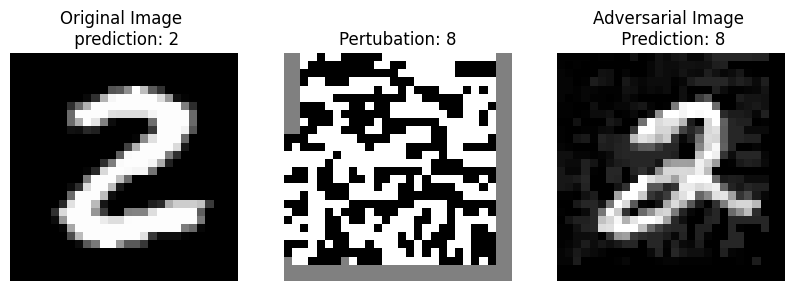

In [22]:
fig = plt.figure(figsize=(10, 10))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(org_image, cmap='gray')
plt.axis('off')
plt.title(f'Original Image \n prediction: {org_pred}')

fig.add_subplot(rows, columns, 2)
plt.imshow(perturbation, cmap='gray')
plt.axis('off')
plt.title(f'Pertubation: {adv_pred}')

fig.add_subplot(rows, columns, 3)
plt.imshow(adv_image, cmap='gray')
plt.axis('off')
plt.title(f'Adversarial Image \n Prediction: {adv_pred}')

### Attack evaluation large model

In [23]:
# flatten the image arrays as a 1D array
org_image_flattened = org_image.flatten()
adv_image_flattened = adv_image.flatten()
print(np.shape(org_image_flattened))
print(np.shape(adv_image_flattened))

# # generating count histogram for the images
# org_image_counter = Counter(org_image_flattened)
# org_image_hist = []

# adv_image_counter = Counter(adv_image_flattened)
# adv_image_hist = []

# for num in range(256):
#   if num in org_image_counter.keys():
#     org_image_hist.append(org_image_counter[num])
#   else:
#     org_image_hist.append(0)

# for num in range(256):
#   if num in adv_image_counter.keys():
#     adv_image_hist.append(adv_image_counter[num])
#   else:
#     adv_image_hist.append(0)


# compute the euclidean distance between the two images
# distance1 = np.linalg.norm(np.array(org_image_hist) - np.array(adv_image_hist))

distance = np.linalg.norm(org_image_flattened - adv_image_flattened)

print(f"Distance: {distance}")


(784,)
(784,)
Distance: 9.834304809570312


## Metrics for small model

(28, 28, 1)


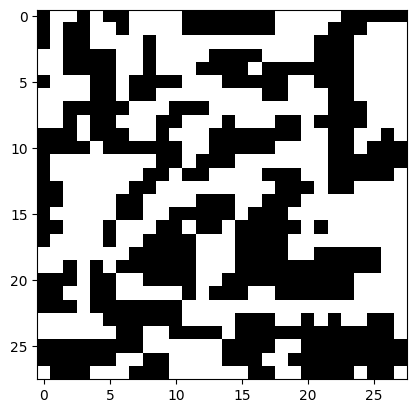

In [16]:
# x_test[5].shape
# digit = x_test[16]
# fig = plt.figure
# plt.imshow(digit, cmap='gray')
# print(y_test[16])

perturbation = np.squeeze(perturbation)
perturbation = np.expand_dims(perturbation, axis=2)
print(perturbation.shape)

plt.imshow(perturbation, cmap='gray')

In [36]:
print(x_test_adv.shape)
print(x.shape)

(1, 28, 28, 1)
(1, 28, 28, 1)


(28, 28, 1)


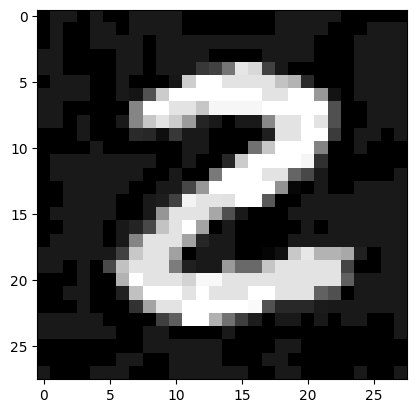

In [17]:
adv_image = np.squeeze(x_test_adv)
adv_image = np.expand_dims(adv_image, axis=2)
print(adv_image.shape)

plt.imshow(adv_image, cmap='gray')

In [41]:
adv_pred = model.predict(x_test_adv)
org_pred = model.predict(x)

org_pred = np.argmax(org_pred[1])
adv_pred = np.argmax(adv_pred[1])
# print(np.argmax(org_pred[1]))
# print(np.argmax(adv_pred[1]))

1/1 [==============================] - 0s 18ms/step


In [28]:
org_image = np.expand_dims(np.squeeze(x), axis=2)
print("orig img", org_image.shape)
print("adv img", adv_image.shape)

orig img (28, 28, 1)
adv img (28, 28, 1)


## Visualizing the data Small Model

Text(0.5, 1.0, 'Adversarial Image \n Prediction: 3')

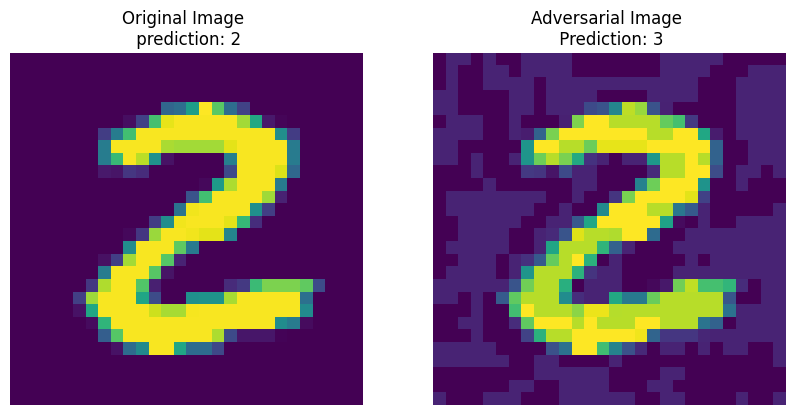

In [42]:
fig = plt.figure(figsize=(10, 10))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(org_image)
plt.axis('off')
plt.title(f'Original Image \n prediction: {org_pred}')

fig.add_subplot(rows, columns, 2)
plt.imshow(perturbation)
plt.axis('off')
plt.title(f'Pertubation: {adv_pred}')

fig.add_subplot(rows, columns, 3)
plt.imshow(adv_image)
plt.axis('off')
plt.title(f'Adversarial Image \n Prediction: {adv_pred}')

## Attack Evaluation - Distance Measure

In [43]:
from PIL import Image
from collections import Counter

In [51]:
# flatten the image arrays as a 1D array
org_image_flattened = org_image.flatten()
adv_image_flattened = adv_image.flatten()
print(np.shape(org_image_flattened))
print(np.shape(adv_image_flattened))

# # generating count histogram for the images
# org_image_counter = Counter(org_image_flattened)
# org_image_hist = []

# adv_image_counter = Counter(adv_image_flattened)
# adv_image_hist = []

# for num in range(256):
#   if num in org_image_counter.keys():
#     org_image_hist.append(org_image_counter[num])
#   else:
#     org_image_hist.append(0)

# for num in range(256):
#   if num in adv_image_counter.keys():
#     adv_image_hist.append(adv_image_counter[num])
#   else:
#     adv_image_hist.append(0)


# compute the euclidean distance between the two images
# distance1 = np.linalg.norm(np.array(org_image_hist) - np.array(adv_image_hist))

distance = np.linalg.norm(org_image_flattened - adv_image_flattened)

print(f"Distance: {distance}")



(784,)
(784,)
Distance 1 287.7377278008569 
 distnace 2 2.1441874504089355
